In [1]:
import json
from abc import ABC, abstractmethod
from dataclasses import dataclass

import numpy as np
from anytree import PreOrderIter
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter

from QHyper.problems.algorithms.graph_utils import SPTreeNode, Composition, CompositionNode
from QHyper.problems.algorithms.solver_utils import WorkflowSchedulingSolverDecorator, \
    DecomposedWorkflowSchedulingSolver, WorkflowSchedule
from QHyper.problems.algorithms.workflow_decomposition import SeriesParallelSplitFinal, Division
from QHyper.problems.workflow_scheduling import Workflow, WorkflowSchedulingOneHot
from QHyper.solvers import Gurobi, solver_from_config

In [2]:
class ExperimentResult(ABC):
    @abstractmethod
    def plot(self):
        pass


@dataclass
class AlgorithmRun:
    max_subgraph_size: int
    decomposition_schedule: WorkflowSchedule
    reference_schedule: WorkflowSchedule


class Experiment(ABC):
    def __init__(self, tasks_file, machines_file, deadline):
        self.tasks_file = tasks_file
        self.machines_file = machines_file
        self.deadline = deadline

    def _get_decomposed_solver(self, max_graph_size: int):
        workflow = Workflow(self.tasks_file, self.machines_file, self.deadline)
        division = SeriesParallelSplitFinal().decompose(workflow, max_graph_size)
        problems = map(lambda w: WorkflowSchedulingOneHot(w), division.workflows)
        solvers = map(lambda p: WorkflowSchedulingSolverDecorator(Gurobi(p)), problems)
        return DecomposedWorkflowSchedulingSolver(list(solvers), division)

    def _get_solver(self):
        solver_config = {
            "problem": {
                "type": "workflow_scheduling",
                "encoding": "one-hot",
                "tasks_file": self.tasks_file,
                "machines_file": self.machines_file,
                "deadline": self.deadline,
            },
            "solver": {
                "type": "gurobi",
            }
        }

        return WorkflowSchedulingSolverDecorator(solver_from_config(solver_config))

    def _schedule(self, max_subgraph_size: int) -> AlgorithmRun:
        return AlgorithmRun(
            max_subgraph_size,
            self._get_decomposed_solver(max_subgraph_size).solve(),
            self._get_solver().solve()
        )

    @abstractmethod
    def run(self) -> ExperimentResult:
        pass


def deadline_as_cpv(tasks_file, machines_file):
    workflow = Workflow(tasks_file, machines_file, 100000)
    return int(workflow.critical_path_value)

In [3]:
class MssInfluenceExperiment(Experiment):
    def __init__(self, tasks_file, machines_file, max_subgraph_sizes: list[int]):
        super().__init__(tasks_file, machines_file, deadline_as_cpv(tasks_file, machines_file))
        self.max_subgraph_sizes: list[int] = max_subgraph_sizes

    class MssInfluenceExperimentResult(ExperimentResult):
        def __init__(self, algorithm_runs: list[AlgorithmRun]):
            self.algorithm_runs = algorithm_runs
            self.cost_increase_per_mss = self._get_result_dict()

        def _get_result_dict(self) -> dict[int, float]:
            result = {}
            for algorithm_run in self.algorithm_runs:
                result[algorithm_run.max_subgraph_size] = self._calculate_cost_increase_ratio(algorithm_run)
            return result

        @staticmethod
        def _calculate_cost_increase_ratio(algorithm_run: AlgorithmRun) -> float:
            return algorithm_run.decomposition_schedule.cost / algorithm_run.reference_schedule.cost

        def plot(self, title: str = None):
            fig, ax = plt.subplots(1, 1, figsize=(15, 6))
            ax.plot(self.cost_increase_per_mss.keys(), self.cost_increase_per_mss.values(), 'o-', linewidth=2)
            ax.set_xlabel('Max subgraph size')
            ax.set_ylabel('Relative schedule cost increase')
            if title:
                ax.set_title(title)
            plt.show()
            
        def save_as_json(self, filename: str):
            with open(filename, 'w') as file:
                json.dump(obj=self.cost_increase_per_mss, fp=file, indent=4)

    def run(self) -> ExperimentResult:
        schedules = []
        for mss in self.max_subgraph_sizes:
            try:
                schedules.append(self._schedule(mss))
            except Exception as e:
                print(f"Unable to solve for max subgraph size = {mss}")
        return self.MssInfluenceExperimentResult(schedules)  

In [4]:
def measure_mss_influence_for_workflow_family(workflows: list[str], machines_file: str, divisions: list[float]):
    experiment_results: dict[int, MssInfluenceExperiment.MssInfluenceExperimentResult] = {}
    for tasks_file in workflows:
        workflow_size = len(Workflow(tasks_file, machines_file, 100000).tasks)
        max_subgraph_sizes = [int(multiplier * workflow_size) for multiplier in divisions]
        max_subgraph_sizes = [mss for mss in max_subgraph_sizes if mss >= 2]
        mss_influence_experiment = MssInfluenceExperiment(tasks_file, machines_file, max_subgraph_sizes)
        experiment_results[workflow_size] = mss_influence_experiment.run()
    return experiment_results

def plot_for_family(family, experiment_results, divisions, save: bool = True):
    fig, ax = plt.subplots(1, 1, figsize=(18,8))
    
    for size, r in experiment_results.items():
        x = [int(mss * 100) for mss in divisions[:len(r.cost_increase_per_mss.values())]]
        y = [(cost_increase - 1) * 100.0 for cost_increase in r.cost_increase_per_mss.values()]
        ax.plot(x, y, 'o-', linewidth=2, label=f'{size} nodes')
    
    ax.set_xticks([int(division * 100) for division in divisions])
    ax.set_xticklabels(ax.get_xticks(), fontsize=12)
    ax.set_yticklabels(ax.get_yticks(), fontsize=12)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))
    ax.set_xlabel('Max subgraph size relative to workflow size [%]', fontsize=12)
    ax.set_ylabel('Schedule cost increase relative to scheduling without division [%]', fontsize=12)
    ax.set_title(f'Influence of the max subgraph size on the schedule cost for {family} workflows', fontsize=15)
    
    plt.legend(fontsize=12)
    plt.show()
    
    if save:
        fig.savefig(f"mss_influence_results/{family}/cost_increase_plot.png")

def save_family_as_json(family, experiment_results):
    for size, experiment_result in experiment_results.items():
        experiment_result.save_as_json(f"mss_influence_results/{family}/{size}.json")

# Epigenomics family

In [5]:
workflows = [
      "/home/marcin/Programming/pegasus-instances/epigenomics/chameleon-cloud/epigenomics-chameleon-hep-6seq-100k-001.json",
      "/home/marcin/Programming/pegasus-instances/epigenomics/chameleon-cloud/epigenomics-chameleon-hep-1seq-100k-001.json",
      "/home/marcin/Programming/pegasus-instances/epigenomics/chameleon-cloud/epigenomics-chameleon-hep-6seq-50k-001.json",
      "/home/marcin/Programming/pegasus-instances/epigenomics/chameleon-cloud/epigenomics-chameleon-hep-3seq-100k-001.json"
]
machines_file = "../workflows_data/machines/linear_smaller_diff.json"
divisions = [0.75, 0.5, 0.25, 0.15, 0.1, 0.05, 0.02, 0.01]

In [6]:
%%capture
epigenomics_results = measure_mss_influence_for_workflow_family(workflows, machines_file, divisions)

/tmp/ipykernel_15477/2678435487.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=12)


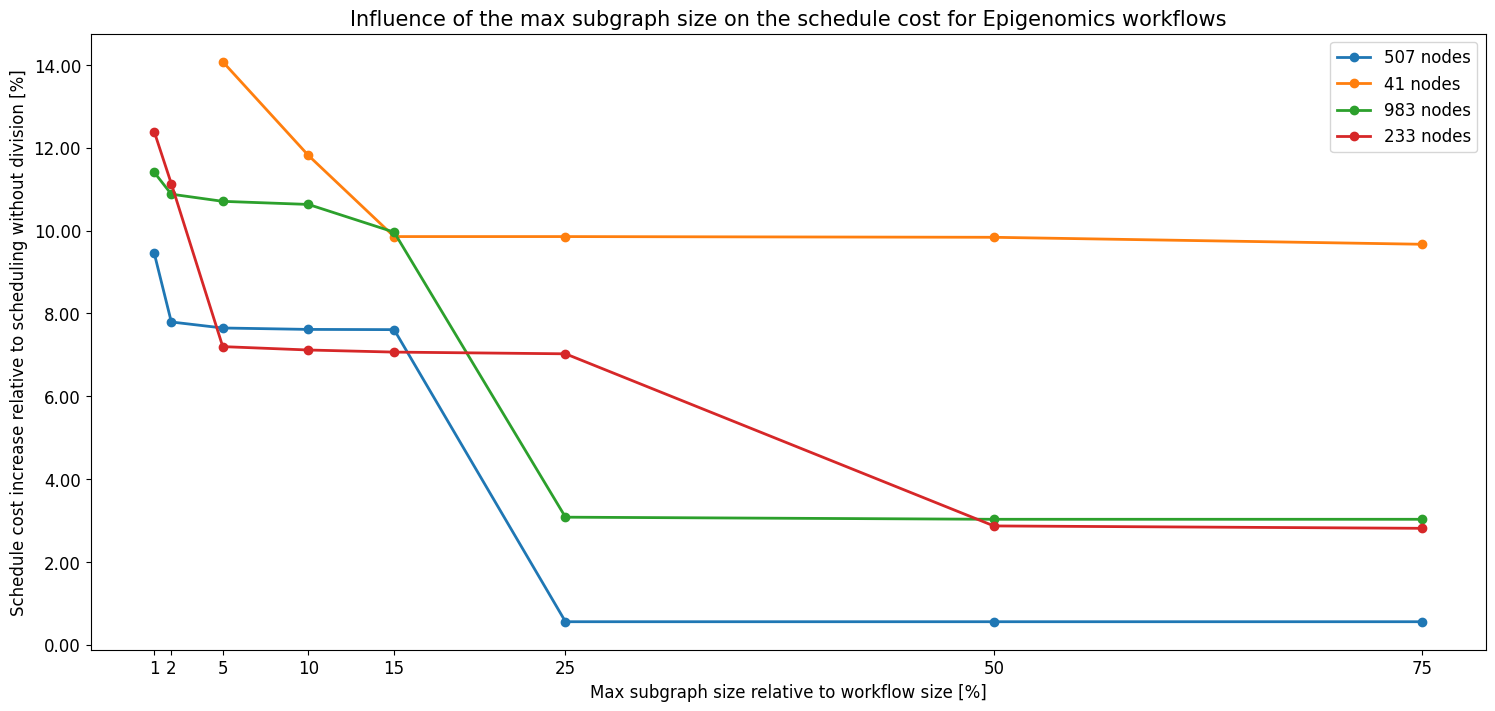

In [16]:
plot_for_family("Epigenomics", epigenomics_results, divisions)

In [9]:
save_family_as_json("Epigenomics", epigenomics_results)

# 1000genome

In [18]:
workflows = [
  "/home/marcin/Programming/pegasus-instances/1000genome/chameleon-cloud/1000genome-chameleon-22ch-100k-001.json",
  "/home/marcin/Programming/pegasus-instances/1000genome/chameleon-cloud/1000genome-chameleon-2ch-250k-001.json",
  "/home/marcin/Programming/pegasus-instances/1000genome/chameleon-cloud/1000genome-chameleon-6ch-250k-001.json",
  "/home/marcin/Programming/pegasus-instances/1000genome/chameleon-cloud/1000genome-chameleon-22ch-250k-001.json"
]
machines_file = "../workflows_data/machines/linear_smaller_diff.json"
divisions = [0.75, 0.5, 0.25, 0.15, 0.1, 0.05, 0.02, 0.01]

In [19]:
%%capture
family_results = measure_mss_influence_for_workflow_family(workflows, machines_file, divisions)

/tmp/ipykernel_15477/2678435487.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=12)


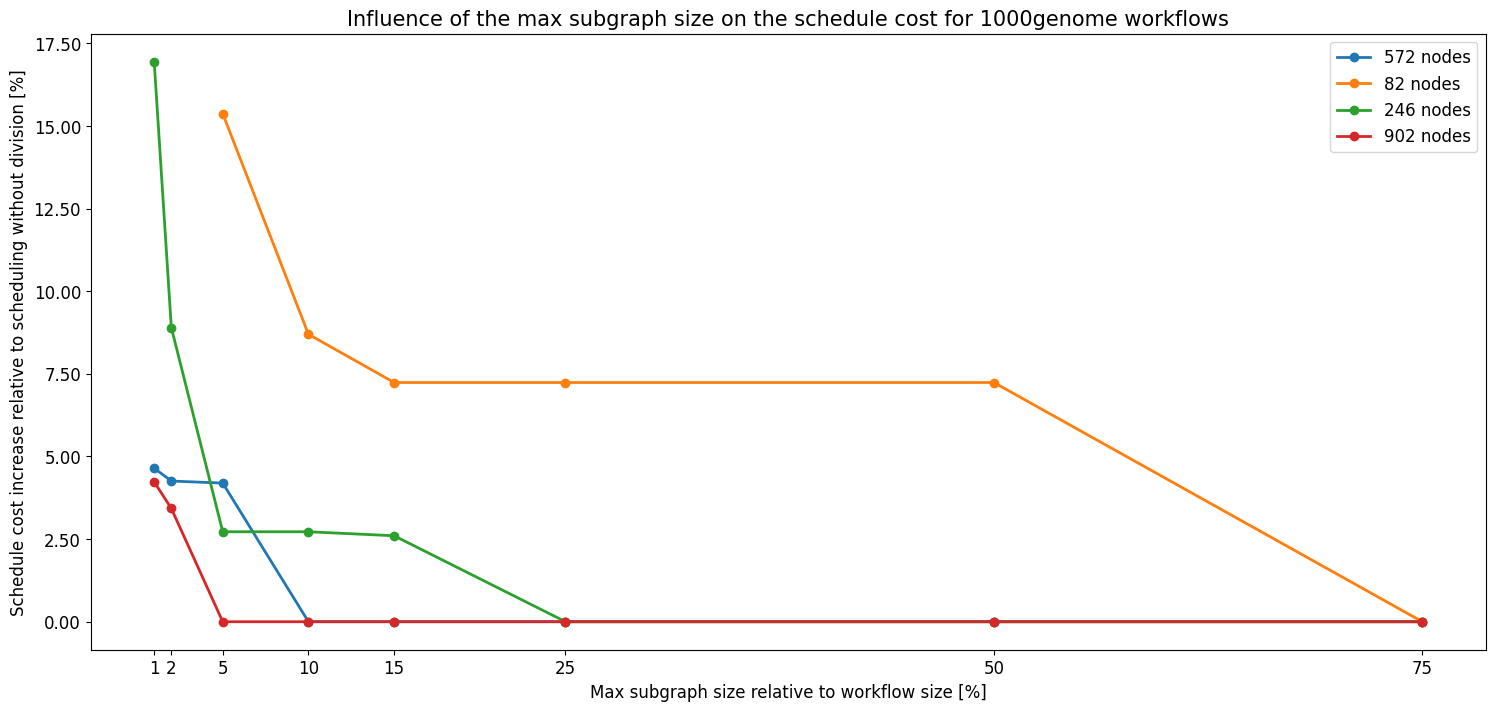

In [22]:
plot_for_family("1000genome", family_results, divisions, True)

In [23]:
save_family_as_json("1000genome", family_results)

# SRA Search

In [10]:
workflows = [
  "/home/marcin/Programming/pegasus-instances/srasearch/chameleon-cloud/srasearch-chameleon-30a-001.json",
  "/home/marcin/Programming/pegasus-instances/srasearch/chameleon-cloud/srasearch-chameleon-20a-001.json",
  "/home/marcin/Programming/pegasus-instances/srasearch/chameleon-cloud/srasearch-chameleon-40a-001.json",
  "/home/marcin/Programming/pegasus-instances/srasearch/chameleon-cloud/srasearch-chameleon-10a-001.json"
]
machines_file = "../workflows_data/machines/linear_smaller_diff.json"
divisions = [0.75, 0.5, 0.25, 0.15, 0.1, 0.05, 0.02, 0.01]

In [11]:
%%capture
sra_results = measure_mss_influence_for_workflow_family(workflows, machines_file, divisions)

/tmp/ipykernel_15477/2678435487.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=12)


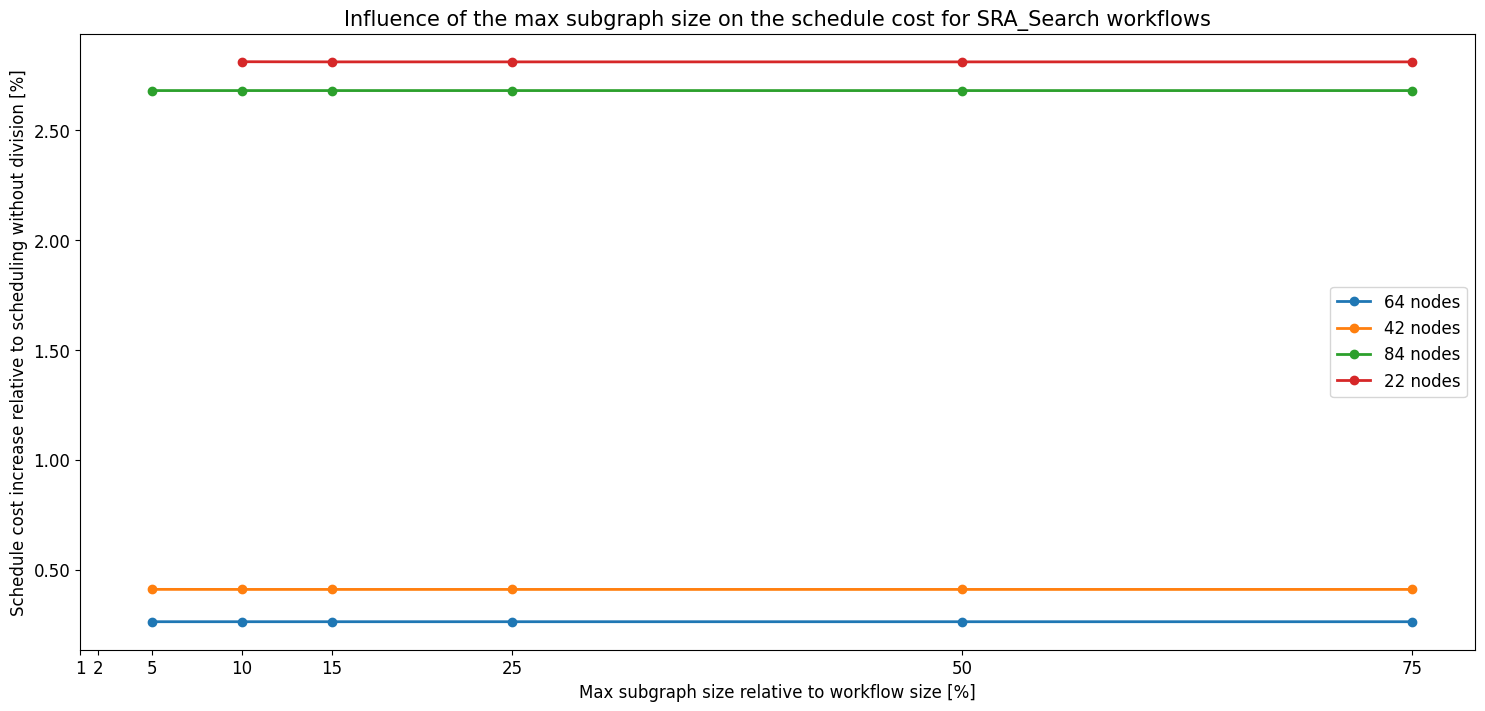

In [17]:
plot_for_family("SRA_Search", sra_results, divisions)

In [20]:
save_family_as_json("SRA_Search", sra_results)

# Tree structure

In [88]:
class TreeMetrics:
    def __init__(self, tree: SPTreeNode):
        self.tree = tree
        
    def series_nodes_number(self):
        return len(self.series_nodes())

    def parallel_nodes_number(self):
        return len(self.parallel_nodes())
    
    def series_nodes(self):
        composition_nodes = self._composition_nodes()
        return [n for n in composition_nodes if n.operation == Composition.SERIES]
    
    def parallel_nodes(self):
        composition_nodes = self._composition_nodes()
        return [n for n in composition_nodes if n.operation == Composition.PARALLEL]
    
    def _composition_nodes(self):
        return [n for n in PreOrderIter(self.tree) if isinstance(n, CompositionNode)]

class TreeStructureExperiment(Experiment):
    def __init__(self, tasks_file, machines_file, max_subgraph_sizes: list[int]):
        super().__init__(tasks_file, machines_file, deadline_as_cpv(tasks_file, machines_file))
        self.max_subgraph_sizes: list[int] = max_subgraph_sizes

    class TreeStructureExperimentResult(ExperimentResult):
        def __init__(self, mss_to_division: dict[int, Division]):
            self.mss_to_division = mss_to_division
            self.series_nodes_number_per_mss = {}
            self.parallel_nodes_number_per_mss = {}
            self.series_nodes_density_per_mss = {}
            self.series_nodes_weighted_sum = {}
            self.parallel_nodes_weighted_sum = {}
            self.series_nodes_weighted_by_tree_depth = {}
            self._extract_tree_data()

        def _extract_tree_data(self):
            for mss, division in self.mss_to_division.items():
                tree_metrics = TreeMetrics(division.tree)
                total_node_number = len(division.tree.get_graph_nodes())
                series_nodes_count = tree_metrics.series_nodes_number()
                parallel_nodes_count = tree_metrics.parallel_nodes_number()
                self.series_nodes_number_per_mss[mss] = series_nodes_count
                self.parallel_nodes_number_per_mss[mss] = parallel_nodes_count
                self.series_nodes_density_per_mss[mss] = series_nodes_count / (series_nodes_count + parallel_nodes_count)
                self.series_nodes_weighted_sum[mss] = sum(map(lambda n: len(n.get_graph_nodes()) / total_node_number, tree_metrics.series_nodes()))
                self.parallel_nodes_weighted_sum[mss] = sum(map(lambda n: len(n.get_graph_nodes()), tree_metrics.parallel_nodes()))
                self.series_nodes_weighted_by_tree_depth[mss] = sum(map(lambda n: n.height, tree_metrics.series_nodes()))

        def plot(self, title: str = None):
            fig, axs = plt.subplots(1, 2, figsize=(15, 6))
            axs[0].plot(self.series_nodes_number_per_mss.keys(), self.series_nodes_number_per_mss.values(), 'o-', linewidth=2)
            axs[0].set_xlabel('Max subgraph size')
            axs[0].set_ylabel('Number of series nodes')
            
            axs[1].plot(self.series_nodes_density_per_mss.keys(), self.series_nodes_density_per_mss.values(), 'o-', linewidth=2)
            axs[1].set_xlabel('Max subgraph size')
            axs[1].set_ylabel('Density of series nodes')
            if title:
                axs.set_title(title)
            plt.show()
            
        # def save_as_json(self, filename: str):
        #     with open(filename, 'w') as file:
        #         json.dump(obj=self.cost_increase_per_mss, fp=file, indent=4)

    def run(self) -> ExperimentResult:
        division_per_mss = {mss: self._get_decomposed_solver(mss).division for mss in self.max_subgraph_sizes}
        return self.TreeStructureExperimentResult(division_per_mss)

In [95]:
def extract_tree_structure_for_workflow_family(workflows: list[str], machines_file: str, divisions: list[float]):
    experiment_results: dict[int, TreeStructureExperiment.TreeStructureExperimentResult] = {}
    for tasks_file in workflows:
        workflow_size = len(Workflow(tasks_file, machines_file, 100000).tasks)
        max_subgraph_sizes = [int(multiplier * workflow_size) for multiplier in divisions]
        max_subgraph_sizes = [mss for mss in max_subgraph_sizes if mss >= 2]
        tree_experiment = TreeStructureExperiment(tasks_file, machines_file, max_subgraph_sizes)
        experiment_results[workflow_size] = tree_experiment.run()
    return experiment_results

def plot_tree_analysis_for_family(family, experiment_results, divisions, save: bool = True):
    fig, axs = plt.subplots(3, 1, figsize=(18,18))
    
    for size, r in experiment_results.items():
        x = [int(mss * 100) for mss in divisions[:len(r.series_nodes_number_per_mss.values())]]
        y1 = list(r.series_nodes_number_per_mss.values())
        # y1_1 = list(r.parallel_nodes_number_per_mss.values())
        # y2 = list(r.series_nodes_density_per_mss.values())
        y2 = list(r.series_nodes_weighted_sum.values())
        y3 = list(r.series_nodes_weighted_by_tree_depth.values())
        axs[0].plot(x, y1, 'o-', linewidth=2, label=f'{size} nodes')
        # axs[0].plot(x, y1_1, 'o-', linewidth=2, label=f'parallel nodes')
        axs[1].plot(x, y2, 'o-', linewidth=2, label=f'{size} nodes')
        axs[2].plot(x, y3, 'o-', linewidth=2, label=f'{size} nodes')
    
    axs[0].set_xticks([int(division * 100) for division in divisions])
    axs[0].set_xticklabels(axs[0].get_xticks(), fontsize=12)
    axs[0].set_yticklabels(axs[0].get_yticks(), fontsize=12)
    axs[0].set_xlabel('Max subgraph size relative to workflow size [%]', fontsize=12)
    axs[0].set_ylabel('Number of series nodes', fontsize=12)
    axs[0].legend(fontsize=12)
    
    axs[1].set_xticks([int(division * 100) for division in divisions])
    axs[1].set_xticklabels(axs[0].get_xticks(), fontsize=12)
    axs[1].set_yticklabels(axs[0].get_yticks(), fontsize=12)
    axs[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))
    axs[1].set_xlabel('Max subgraph size relative to workflow size [%]', fontsize=12)
    # axs[1].set_ylabel('Density of series nodes', fontsize=12)
    axs[1].set_ylabel('Weighted sum of series nodes', fontsize=12)
    axs[1].legend(fontsize=12)
    
    axs[2].set_xticks([int(division * 100) for division in divisions])
    axs[2].set_xticklabels(axs[0].get_xticks(), fontsize=12)
    axs[2].set_yticklabels(axs[0].get_yticks(), fontsize=12)
    axs[2].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))
    axs[2].set_xlabel('Max subgraph size relative to workflow size [%]', fontsize=12)
    # axs[1].set_ylabel('Density of series nodes', fontsize=12)
    axs[2].set_ylabel('Sum of series nodes weighted by tree height', fontsize=12)
    axs[2].legend(fontsize=12)
    
    plt.suptitle(f'Binary decomposition tree structure per max subgraph size for {family} workflows', fontsize=15)
    # plt.legend(fontsize=12)
    plt.show()

# Epigenomics

In [90]:
workflows = [
      "/home/marcin/Programming/pegasus-instances/epigenomics/chameleon-cloud/epigenomics-chameleon-hep-6seq-100k-001.json",
      "/home/marcin/Programming/pegasus-instances/epigenomics/chameleon-cloud/epigenomics-chameleon-hep-1seq-100k-001.json",
      "/home/marcin/Programming/pegasus-instances/epigenomics/chameleon-cloud/epigenomics-chameleon-hep-6seq-50k-001.json",
      "/home/marcin/Programming/pegasus-instances/epigenomics/chameleon-cloud/epigenomics-chameleon-hep-3seq-100k-001.json"
]
machines_file = "../workflows_data/machines/linear_smaller_diff.json"
divisions = [0.75, 0.5, 0.25, 0.15, 0.1, 0.05, 0.02, 0.01]

In [97]:
epigenomics_single_instance_tree_results = extract_tree_structure_for_workflow_family(workflows[:1], machines_file, divisions)

/tmp/ipykernel_7910/3174843771.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(axs[0].get_yticks(), fontsize=12)
/tmp/ipykernel_7910/3174843771.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels(axs[0].get_yticks(), fontsize=12)
/tmp/ipykernel_7910/3174843771.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_yticklabels(axs[0].get_yticks(), fontsize=12)


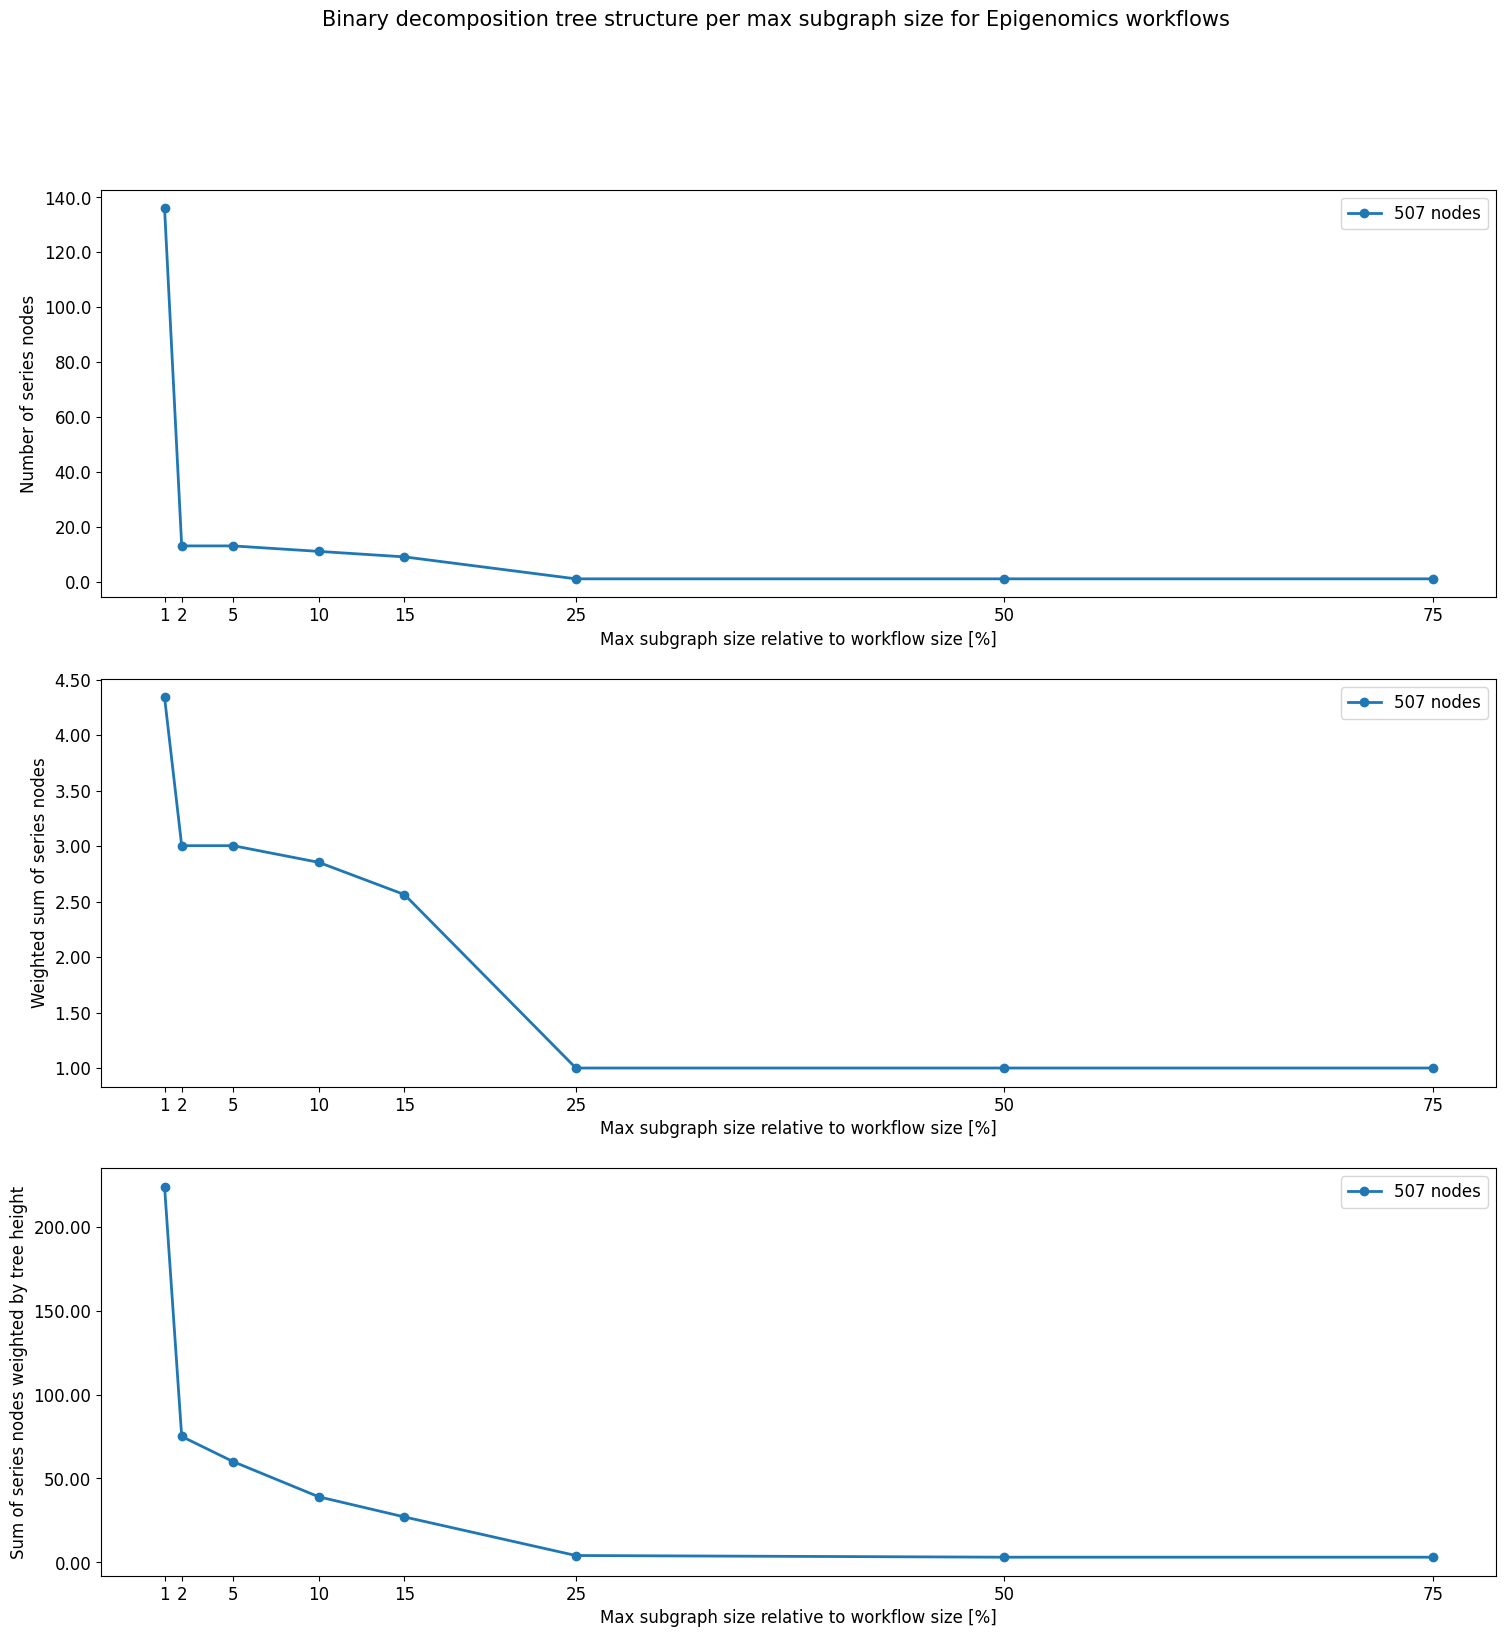

In [98]:
plot_tree_analysis_for_family("Epigenomics", epigenomics_single_instance_tree_results, divisions, False)

In [91]:
epigenomics_tree_results = extract_tree_structure_for_workflow_family(workflows, machines_file, divisions)

/tmp/ipykernel_7910/3174843771.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(axs[0].get_yticks(), fontsize=12)
/tmp/ipykernel_7910/3174843771.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels(axs[0].get_yticks(), fontsize=12)
/tmp/ipykernel_7910/3174843771.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_yticklabels(axs[0].get_yticks(), fontsize=12)


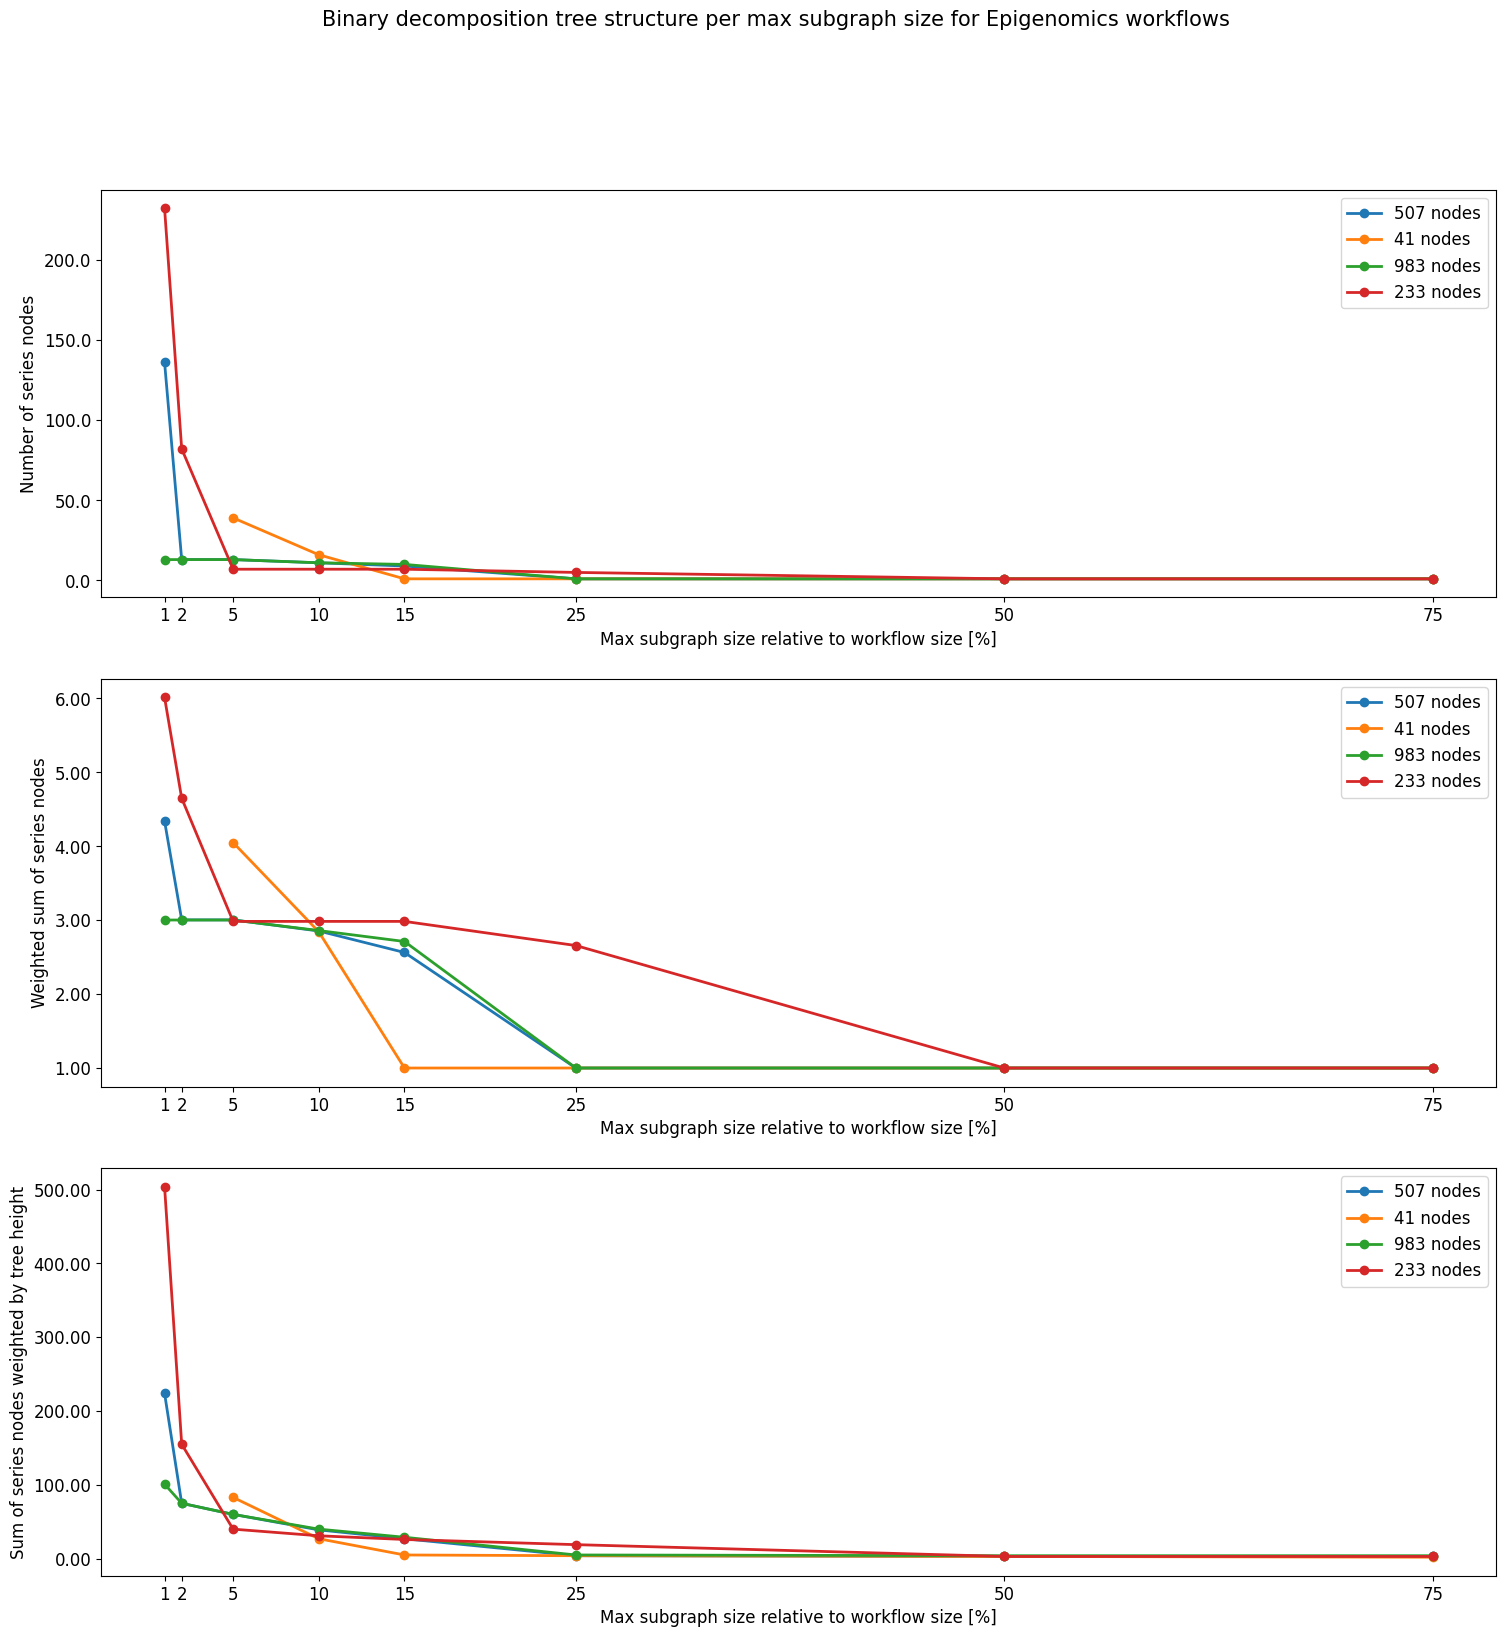

In [96]:
plot_tree_analysis_for_family("Epigenomics", epigenomics_tree_results, divisions, False)

# SRA Search

In [78]:
workflows = [
  "/home/marcin/Programming/pegasus-instances/srasearch/chameleon-cloud/srasearch-chameleon-30a-001.json",
  "/home/marcin/Programming/pegasus-instances/srasearch/chameleon-cloud/srasearch-chameleon-20a-001.json",
  "/home/marcin/Programming/pegasus-instances/srasearch/chameleon-cloud/srasearch-chameleon-40a-001.json",
  "/home/marcin/Programming/pegasus-instances/srasearch/chameleon-cloud/srasearch-chameleon-10a-001.json"
]
machines_file = "../workflows_data/machines/linear_smaller_diff.json"
divisions = [0.75, 0.5, 0.25, 0.15, 0.1, 0.05, 0.02, 0.01]

In [79]:
sra_search_tree_results = extract_tree_structure_for_workflow_family(workflows, machines_file, divisions)

/tmp/ipykernel_7910/870835619.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(axs[0].get_yticks(), fontsize=12)
/tmp/ipykernel_7910/870835619.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels(axs[0].get_yticks(), fontsize=12)
/tmp/ipykernel_7910/870835619.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_yticklabels(axs[0].get_yticks(), fontsize=12)


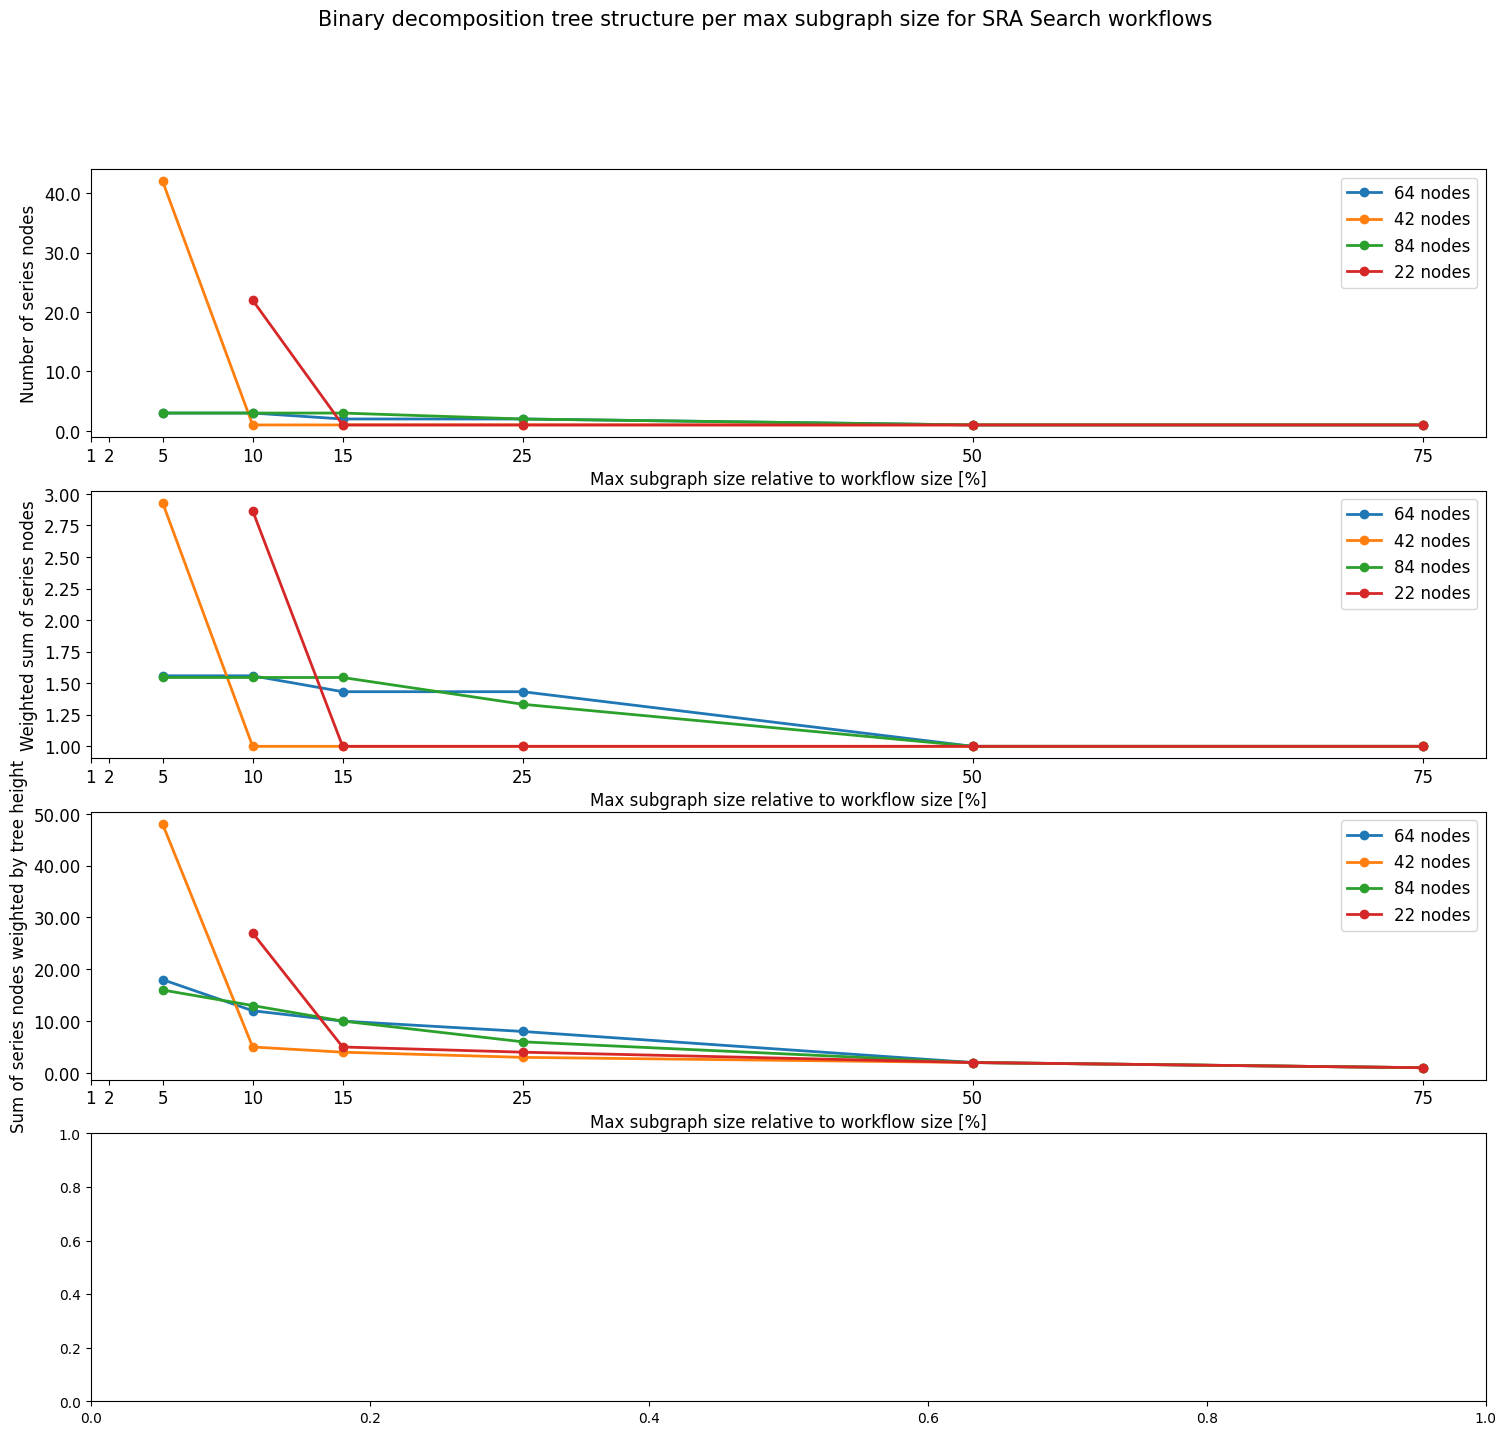

In [81]:
plot_tree_analysis_for_family("SRA Search", sra_search_tree_results, divisions, False)

# 1000genome

In [85]:
workflows = [
  "/home/marcin/Programming/pegasus-instances/1000genome/chameleon-cloud/1000genome-chameleon-22ch-100k-001.json",
  "/home/marcin/Programming/pegasus-instances/1000genome/chameleon-cloud/1000genome-chameleon-2ch-250k-001.json",
  "/home/marcin/Programming/pegasus-instances/1000genome/chameleon-cloud/1000genome-chameleon-6ch-250k-001.json",
  "/home/marcin/Programming/pegasus-instances/1000genome/chameleon-cloud/1000genome-chameleon-22ch-250k-001.json"
]
machines_file = "../workflows_data/machines/linear_smaller_diff.json"
divisions = [0.75, 0.5, 0.25, 0.15, 0.1, 0.05, 0.02, 0.01]

In [86]:
genome_results = extract_tree_structure_for_workflow_family(workflows, machines_file, divisions)

/tmp/ipykernel_7910/263388347.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(axs[0].get_yticks(), fontsize=12)
/tmp/ipykernel_7910/263388347.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels(axs[0].get_yticks(), fontsize=12)
/tmp/ipykernel_7910/263388347.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_yticklabels(axs[0].get_yticks(), fontsize=12)
/tmp/ipykernel_7910/263388347.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[3].set_yticklabels(axs[0].get_yticks(), fontsize=12)


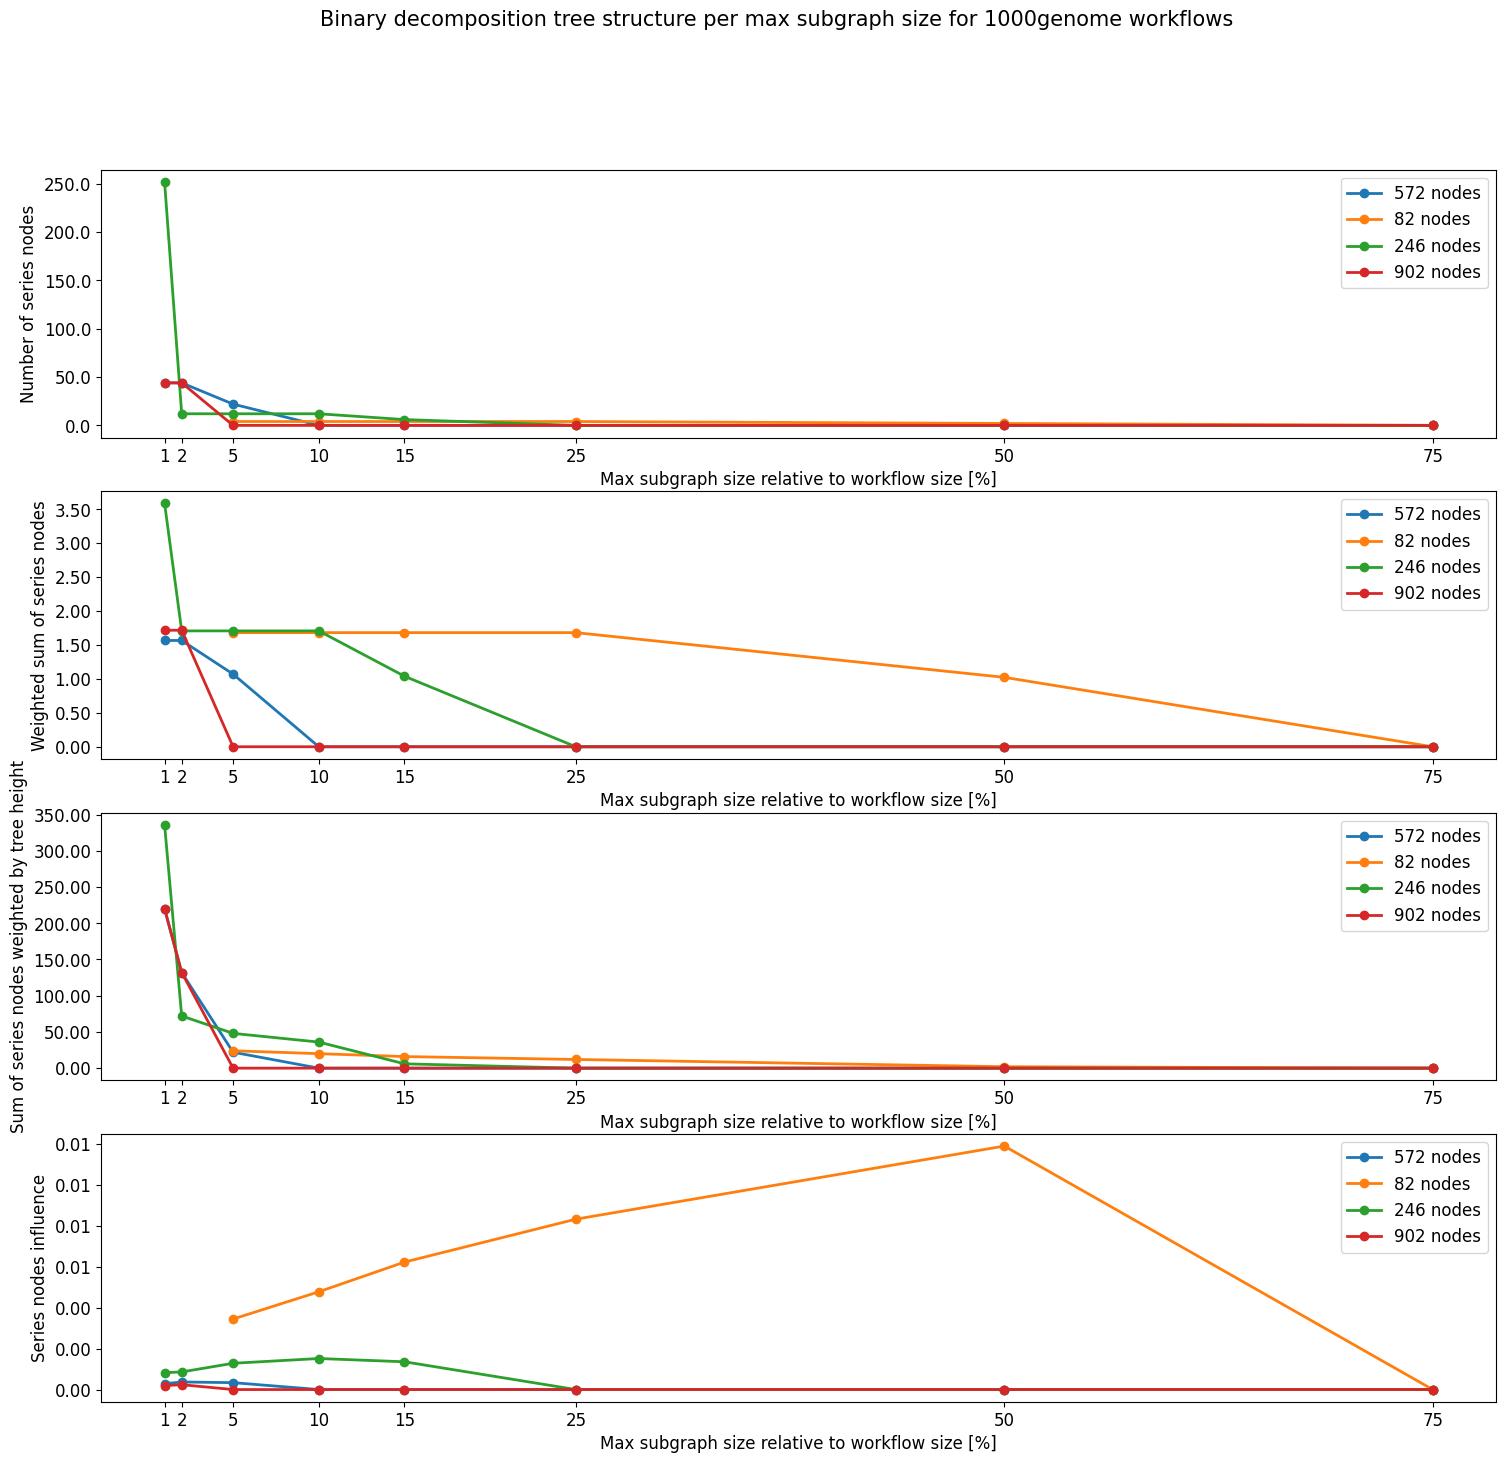

In [87]:
plot_tree_analysis_for_family("1000genome", genome_results, divisions, False)